# Data Augmentation

In [1]:
import torch
from torch import nn
from torchvision import transforms

from PIL import Image

from train_utils import visualize_image

데이터 증강(Data Augmentation)이란 이미지의 의미(semantic)을 바꾸지지 않으면서, 하나의의 이미지를 여러 방식으로 변형하여 딥러닝 모델이 더 다양한 데이터를 학습할 수 있도록 도와주는는 기법입니다.

PyTorch에서는 `transform` 클래스를 정의하여 데이터 증강을 수행할 수 있습니다다.

사용자 정의 `transform` 클래스를 만들기기 위해서는 `__init__` 과 `__call__` 메서드를 구현한 호출 가능한(callable) 클래스를 정의해야 합니다.

아래 예시는 확률 `p`로 좌우 반전(horizontal flip)을 수행하는 사용자 정의 `transform` 클래스입니다.
- `__init__` : 반전을 수행할 확률 p를 하이퍼파라미터로 받아 저장합니다.
- `__call__` : 이미지(`image`)를 입력받아 `torch.rand(1).item()`를 통해 생성된 랜덤 값이 `self.p`보다 작으면 좌우 반전을 수행합니다.
  - [`torch.flip()`](https://docs.pytorch.org/docs/stable/generated/torch.flip.html)함수를 이용합니다.

In [2]:
class CustomRandomHorizontalFlip:
    """Randomly flip a tensor image horizontally with a given probability p."""
    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, image):
        """
        Args:
            image (Tensor): Image to be flipped, shape (C, H, W).
        """
        if torch.rand(1).item() < self.p:
            image = torch.flip(image, dims = [2])   # Flip along the width dimension
        return image

image_tensor.shape:  torch.Size([3, 800, 1200])


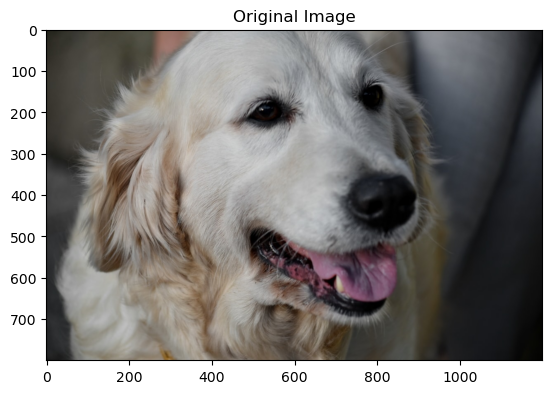

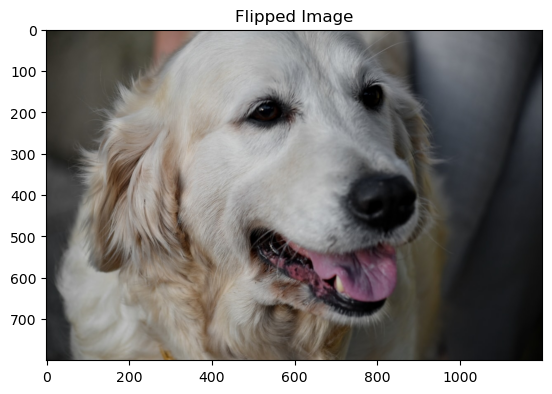

In [3]:
image_pil = Image.open("resources/dog-01.jpg")

image_tensor = transforms.ToTensor()(image_pil) # PIL Image to Torch Tensor
image_flipped = CustomRandomHorizontalFlip(p=0.5)(image_tensor)
print("image_tensor.shape: ", image_tensor.shape)

visualize_image(image_tensor, title="Original Image")
visualize_image(image_flipped, title="Flipped Image")

<mark>실습</mark> CustomRandomCrop 클래스 구현하기

잘라낼 이미지의 크기 `size`를 튜플로 전달받아, 이미지에서 무작위 위치를 잘라내는(crop) `CustomRandomCrop` 클래스를 완성하세요

- 입력 이미지는 `(C, H, W)` 형태의 `Tensor`입니다.
- `torch.randint`를 이용하여 이미지 내 무작위 위치 `(top, left)`를 시작점으로 선택합니다.
- 선택된 시작점에서부터 우하단(bottom-right) 방향으로 `(self.crop_height, self.crop_width)` 크기만큼 이미지를 슬라이싱하여 잘라냅니다.
  - 참고: 이미지 좌표계에서 좌상단(top-left)의 인덱스는 `(0,0)`, 우하단(bottom-right)의 인덱스는 `(H - 1, W - 1)`입니다.
- 출력 이미지는 `(C, self.crop_height, self.crop_width)` 형태의 텐서입니다.

In [4]:
class CustomRandomCrop:
    """Randomly crop a tensor image to the specified size."""
    def __init__(self, size):
        self.crop_height, self.crop_width = size

    def __call__(self, img):
        _, img_height, img_width = img.shape

        top = torch.randint(0, img_height - self.crop_height + 1, (1,)).item()
        left = torch.randint(0, img_width - self.crop_width + 1, (1,)).item()

        img_cropped = img[:, top:top + self.crop_height, left:left + self.crop_width] # TODO

        return img_cropped

image_tensor.shape:  torch.Size([3, 800, 1200])
image_cropped.shape:  torch.Size([3, 224, 224])


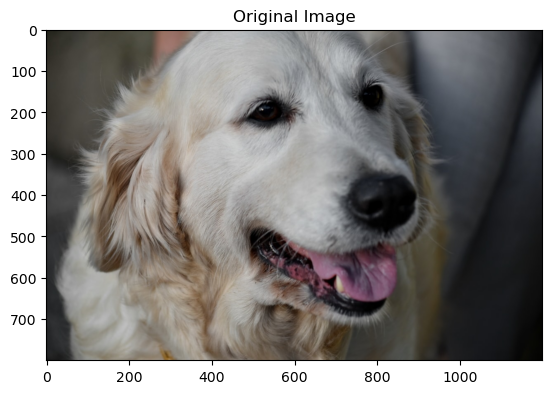

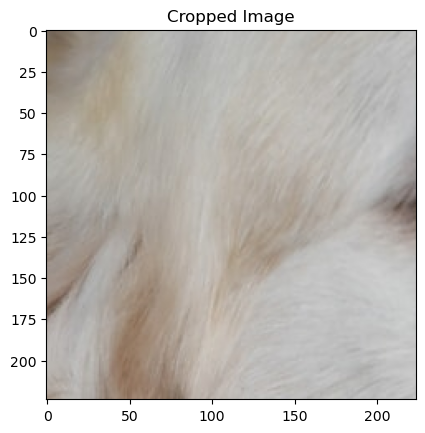

In [5]:
image_pil = Image.open("resources/dog-01.jpg")

image_tensor = transforms.ToTensor()(image_pil) # PIL Image to Torch Tensor
image_cropped = CustomRandomCrop(size = (224, 224))(image_tensor)

assert image_cropped.shape == (3, 224, 224), "Image shape is not correct after CustomRandomCrop"

print("image_tensor.shape: ", image_tensor.shape)
print("image_cropped.shape: ", image_cropped.shape)

visualize_image(image_tensor, title="Original Image")
visualize_image(image_cropped, title="Cropped Image")

In [6]:
torch.manual_seed(0)
image_cropped = CustomRandomCrop(size = (224, 224))(image_tensor)

assert torch.allclose(image_cropped.sum(dim = [1, 2]), torch.tensor([19181.27734375, 16130.005859375, 17805.90234375]), rtol = 1e-3), "Image is not cropped correctly"

print('\033[92mAll tests passed!')

All tests passed!


[`transforms.Compose`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html)를 이용하여 여러개의 Transform을 조합하여 하나의 파이프라인을 구성할 수 있습니다.

Original image shape:  torch.Size([3, 800, 1200])
Augmented image shape:  torch.Size([3, 224, 224])


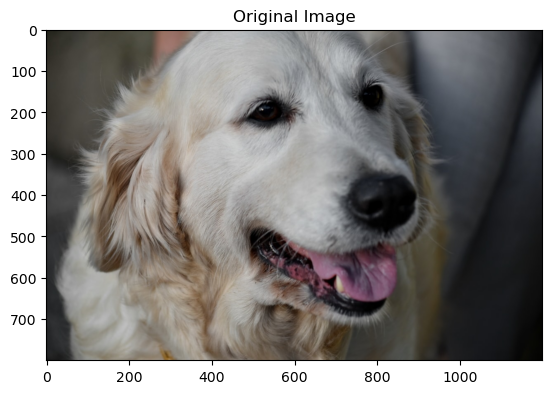

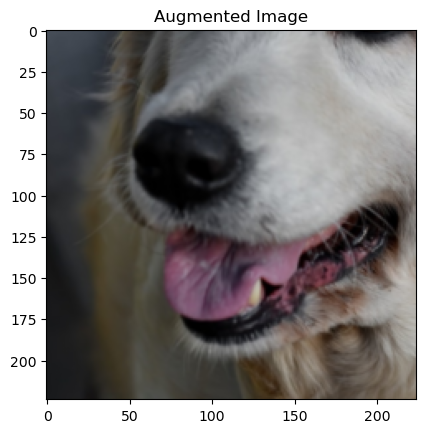

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    CustomRandomHorizontalFlip(p=0.5),
    transforms.Resize(size = (320, 480)),
    CustomRandomCrop(size = (224, 224))
])

image_augmented = transform(image_pil)

print("Original image shape: ", image_tensor.shape)
print("Augmented image shape: ", image_augmented.shape)
visualize_image(image_tensor, title="Original Image")
visualize_image(image_augmented, title="Augmented Image")

PyTorch의 `torchvision.transforms` 모듈에는 이미지 전처리와 증강을 위한 다양한 `transform` 클래스들이 정의되어 있습니다. 그 중 자주 사용되는 주요 `transform`들을 아래에 소개합니다.

- [`transforms.RandomHorizontalFlip(p=0.5)`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html): 이미지를 확률 `p`로 좌우 반전
- [`transforms.RandomCrop(size, padding)`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html): 지정한 크기(`size`)만큼 이미지를 무작위로 자릅니다. `padding`값이 주어지면 자르기 전에 이미지 가장자리에 패딩을 추가합니다
- [`transforms.Resize(size)`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) : 이미지를 지정한 크기(`size`)로 resize합니다. 이미지 비율이 유지되지 않을 수 있습니다.
-[ `transforms.RandomResizedCrop(size, scale)`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html) : 원본 이미지에서 무작위 위치와 크기의 영역을 잘라낸 후, 지정된 크기(size)로 리사이즈합니다. `scale`은 잘래낼 영역의 면적이 원본 이미지 면적에서 차지하는 비율의 범위를 지정합니다.
- [`transforms.ColorJitter()`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html): 밝기, 대비, 채도, 색조를 무작위로 변화시켜 이미지 색감을 다양화합니다
- [`transforms.RandomRotation(degrees)`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html): 이미지를 지정된 각도 범위(`degrees`) 내에서 무작위로 회전합니다
- [`transforms.ToTensor()`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) : PIL 이미지 또는 Numpy 배열을 PyTorch에서 사용하는 (C, H, W) 형태의 `Tensor`로 변환하고, 픽셀값을 `[0, 255]`에서 `[0.0, 1.0]` 범위로 정규화 합니다
- [`transforms.Normalize(mean, std)`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html): 이미지 텐서를 정규화합니다. 각 채널별로 `(x - mean) / std` 연산을 수행합니다.


<mark>실습</mark> 아래 `transform` 파이프라인을 수정하여 다양한 data augmentation을 수행해보세요.

Original image shape:  torch.Size([3, 800, 1200])
Augmented image shape:  torch.Size([3, 300, 450])


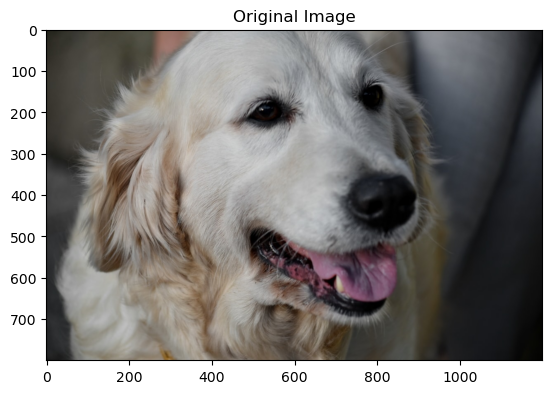

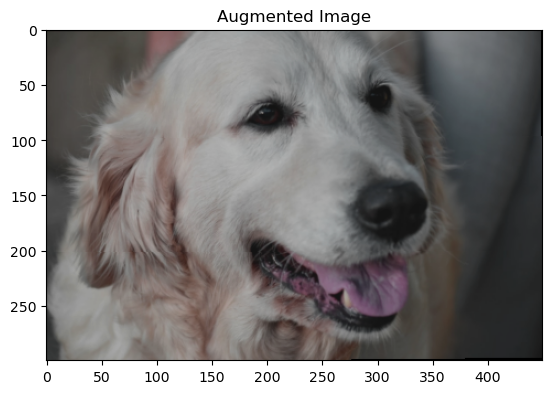

In [8]:
transform = transforms.Compose([
    transforms.Resize(size = (320, 480)),
    # TODO
    transforms.RandomCrop(size=(300, 450), padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

image_augmented = transform(image_pil)

print("Original image shape: ", image_tensor.shape)
print("Augmented image shape: ", image_augmented.shape)
visualize_image(image_tensor, title="Original Image")
visualize_image(image_augmented, title="Augmented Image")

# Batch Normalization

In [9]:
import torch
from torch import nn

Batch Normalization은 딥러닝 모델의 각 레이어(layer) 출력값을 미니배치 단위로 정규화하여, 다음 레이어에 전달되는 입력값의 분포를 일정하게 유지시켜 줍니다. 이를 통해 다음과 같은 학습상의 장점을 제공합니다
 - 학습 안정성 향상: 입력 분포가 일정하게 유지되므로(낮은 Internal Covariate Shift) gradient 흐름이 안정적입니다.
 - 학습 속도 증가: 더 높은 learning rate를 사용할 수 있어 수렴 속도가 빨라집니다.
 - 과적합 감소 : regularization 효과를 가집니다

`BatchNorm` 레이어어는 일반적으로로 `Conv2d` (혹은 `Linear`) 레이어 다음, `ReLU` (activation) 앞에 배치됩니다다.

- Conv2d → [`BatchNorm2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) → ReLU
- Linear → [`BatchNorm1d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) → ReLU

이미지는 채널별로 정규화(normalization)를 수행하므로 `BatchNorm2d`의 `num_features`는 `Conv2d` 레이어의 출력 채널 수와 같습니다.

In [10]:
input_image = torch.rand(16, 3, 32, 32) # dummy image data with batch_size 16
conv_layer = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5)
batch_norm_layer = nn.BatchNorm2d(num_features = 8)

conv_layer_output = conv_layer(input_image)
batch_norm_layer_output = batch_norm_layer(conv_layer_output)
print("Conv2d layer output shape\t: ", conv_layer_output.shape)
print("BatchNorm2d layer output shape\t: ", batch_norm_layer_output.shape)

Conv2d layer output shape	:  torch.Size([16, 8, 28, 28])
BatchNorm2d layer output shape	:  torch.Size([16, 8, 28, 28])


<mark>실습</mark> 아래 `SimpleCNN` 모델의 적절한 위치에 `BatchNorm`를 추가하세요
- 모든 `nn.ReLU()` activation앞에 [`BatchNorm2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) 또는 [`BatchNorm1d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)를 추가하세요 (총 3군데)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 7), # (8, 26, 26)
            nn.BatchNorm2d(num_features=8), # TODO
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # (8, 13, 13)

            nn.Conv2d(8, 16, kernel_size = 4),  # (16, 10, 10)
            nn.BatchNorm2d(num_features=16), # TODO
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # (16, 5, 5)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=128),
            nn.BatchNorm1d(num_features=128), # TODO
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=out_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)        # [B, 16, 5, 5]
        x = x.view(x.shape[0], -1)     # Flatten to [B, 400]
        logits = self.fc_layers(x)     # [B, 10]

        return logits

In [12]:
# Test forward pass
model = SimpleCNN(out_dim = 10)
print(model)

X = torch.rand(16, 3, 32, 32) # dummy data for testing with batch_size 16
logits = model(X) 

print("\nlogits.shape: ", logits.shape)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

logits.shape:  torch.Size([16, 10])


<mark>실습</mark> 앞서 정의한 `model = SimpleCNN(out_dim = 10)`의 `BatchNorm`과 관련된 파라미터 수를 직접 손으로 계산하여 숫자로 기입해보세요 (숫자 계산식으로 입력해도 괜찮으나 파이썬 변수를 사용하지 마세요)

In [13]:
num_params_batchnorm1 = 8 * 2   # TODO: number of parameters in 1st BatchNorm2d layer
num_params_batchnorm2 = 16 * 2  # TODO: number of parameters in 2nd BatchNorm2d layer
num_params_batchnorm3 = 128 * 2  # TODO: number of parameters in 1st BatchNorm1d layer

In [14]:
total_params = (num_params_batchnorm1 + num_params_batchnorm2 + num_params_batchnorm3 + 55866)

print(f"Total number of params : {total_params}")

assert sum(p.numel() for p in model.parameters() if p.requires_grad) == total_params, "❌ 계산한 파라미터 수가 실제 모델과 일치하지 않습니다."
print('\033[92mAll tests passed!')

Total number of params : 56170
All tests passed!


# L2 regularization

In [15]:
import torch
import torch.nn as nn

<b>L2 규제 (L2 Regularization)</b>는 딥러닝 모델이 학습 과정에서 과도하게 복잡해지는것을 방지하기 위해 사용되는 기법으로, 모델의 가중치(weight) 값이 과도하게 커지는 것을 억제함으로써 과적합(overfitting)을 방지하고 일반화 성능을 향상시킵니다.

분류(classification) 모델에서 L2 규제를 적용한 전체 손실 함수는 다음과 같이 주어집니다:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{CE}} + \mathcal{L}_{\text{L2}} = \mathcal{L}_{\text{CE}} + \lambda \cdot \frac{1}{m} \sum_{l=1}^{L} \|W^{[l]}\|_F^2
$$

- $ \mathcal{L}_{\text{CE}} $: Cross Entropy Loss (데이터 예측 오차를 기반으로 계산되는 기본 손실함수)
- $ \lambda $: Regularization coefficient (weight decay라고도 불림)  
- $ m $ : 미니배치 크기(batch size)
- $ L $ : 딥러닝 네트워크의 레이어 수
- $ \|W^{[l]}\|_F^2 = \sum_{i,j} (w_{ij}^{[l]})^2 $: 각 레이어의 weight 행렬에 대한 Frobenius norm 제곱 (= 모든 weight값들의 제곱합)  

---

<mark>실습</mark> L2 규제를 포함한 손실함수 클래스 `CrossEntropyWithL2Loss`를 완성하세요

힌트
- [`torch.sum`](https://docs.pytorch.org/docs/stable/generated/torch.sum.html), [`torch.pow`](https://docs.pytorch.org/docs/stable/generated/torch.pow.html), 또는 [`torch.norm`](https://docs.pytorch.org/docs/stable/generated/torch.norm.html)을 활용하세요

In [16]:
class CrossEntropyWithL2Loss(nn.Module):
    """
    Compute Cross-entropy loss with L2 regularization.
    """
    def __init__(self, weight_decay = 0.0):
        """
        Args:
            weight_decay (float): L2 regularization coefficient (λ).
        """
        super().__init__()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='mean')
        self.weight_decay = weight_decay

    def forward(self, logits, targets, model):
        """
        Args:
            logits (Tensor): Model outputs of shape (batch_size, num_classes).
            targets (Tensor): Ground-truth labels of shape (batch_size,).
            model (nn.Module): The neural-network model to regularize.

        Returns:
            Tensor: Scalar loss value.
        """
        ce_loss = self.cross_entropy(logits, targets)

        l2_penalty = torch.tensor(0.0, device=logits.device)
        for name, param in model.named_parameters():
            if param.requires_grad and param.ndim > 1:  # only weights, not biases
                l2_penalty += torch.sum(param.pow(2))    # TODO

        l2_loss = self.weight_decay * l2_penalty / logits.size(0)  # TODO

        total_loss = ce_loss + l2_loss
        return total_loss

In [17]:
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 5)
)

criterion = CrossEntropyWithL2Loss(weight_decay = 1e-4)

inputs = torch.randn(16, 10)            # (batch_size=16, input_dim=10)
targets = torch.randint(0, 5, (16,))    # 5 classes

logits = model(inputs)                  # (16, 5)
loss = criterion(logits, targets, model)

assert torch.allclose(loss, torch.tensor(1.6047970056533813), rtol=1e-6), "Loss value is not correct."
print('\033[92mAll tests passed!')

All tests passed!


### 참고
 - 위 예시에서 볼 수 있듯이이 Loss를 계산하기 위한 `criterion` 객체 또한 `nn.Module`의 하위 클래스임을 확인할 수 있습니다.
 - 즉, `CrossEntropyLoss`, `MSELoss` 등과 같은 손실 함수들도 일반적인 딥러닝 레이어와 동일한 방식으로 정의되고 동작합니다.

### PyTorch에서의 L2 규제

PyTorch에서는 일반적으로 손실 함수에 직접 L2 항을 추가하기보다는, `optimezer`객체에 `weight_decay`값을 전달하여 L2 규제를 수행합니다

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Learning Rate scheduler

In [19]:
import torch
import torch.nn as nn
from train_utils import plot_lr_history

Learning Rate Scheduler는 학습 도중 학습률(learning rate)을 동적으로 조절하여 학습 효율을 높이는 기법입니다. 

PyTorch에서는 `torch.optim.lr_scheduler` 모듈을 통해 다양한 스케줄러를 제공합니다.

## StepLR
[`StepLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)은 지정된 epoch 간격(`step_size`)마다 학습률을 `gamma`배만큼 줄여주는 가장 기본적인 스케듈러 중 하나입니다.

스케쥴러는 `optimizer`내부의 `learning_rate`를 변경시켜야하므로, `scheduler` 객체는 초기화시 `optimizer` 객체를 인자로 전달 받습니다.

In [20]:
num_epochs = 100
learning_rate = 0.1

model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 5)
)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Decay LR by 0.1 every 5 epochs

In [21]:
def simulate_train_model(model, optimizer, scheduler, num_epochs):
    """
    Simulate training the model for a number of epochs.
    """
    lr_history = []

    for epoch in range(num_epochs):
        # train_one_epoch(): Training code would go here
        lr_history.append(optimizer.param_groups[0]['lr']) # log current learning rate

        scheduler.step()
        
    plot_lr_history(lr_history, num_epochs = num_epochs)
    return lr_history

/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


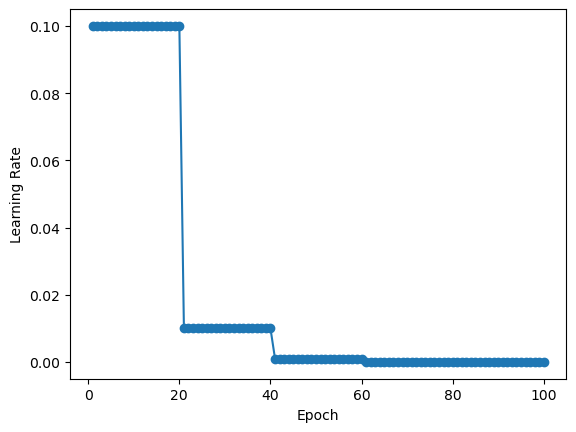

In [22]:
_ = simulate_train_model(model, optimizer, scheduler, num_epochs)

## Learning rate warm-up + decay
2가지 이상의 스케줄러를 순차적으로 적용하고 싶을 때는 [`SequentialLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.SequentialLR.html)를 사용합니다.

아래 예시는 [`LinearLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html)을 이용하여 warm-up을 수행하고 [`StepLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)을 이용하여 learning rate를 점차 줄여줍니다.

/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


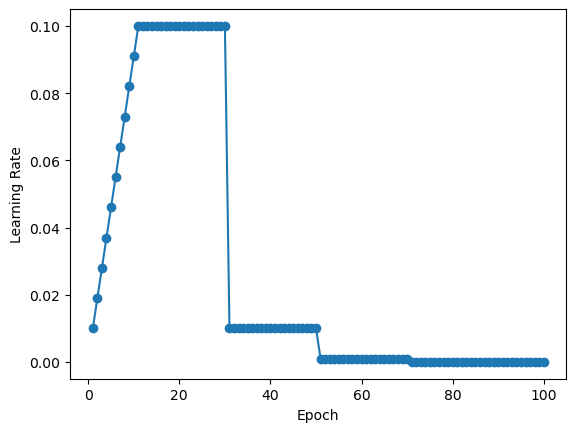

In [23]:
warmup_epochs = int(num_epochs * 0.1)

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor = 0.1,
    end_factor=1.0,
    total_iters=warmup_epochs
)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, step_scheduler],
    milestones=[warmup_epochs]
)

_ = simulate_train_model(model, optimizer, scheduler, num_epochs)

<mark>실습</mark> `CosineAnnealingLR` 적용하기

아래 코드를 수정하여 warm-up 이후, `CosineAnnealingLR`사용하여 learning rate decay를 수행하는 스케쥴러를 구성하세요.
- `CosineAnnealingLR` [문서](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)를 참고하세요
- `T_max`값은 학습률이 최댓값에서 최솟값으로 감소하는데 걸리는 epoch 수이며, cosine곡선의 반주기(half-period)에 해당합니다다.
- `T_max`값이 warn-up 이후 남은 epoch수와 같도록 설정하세요

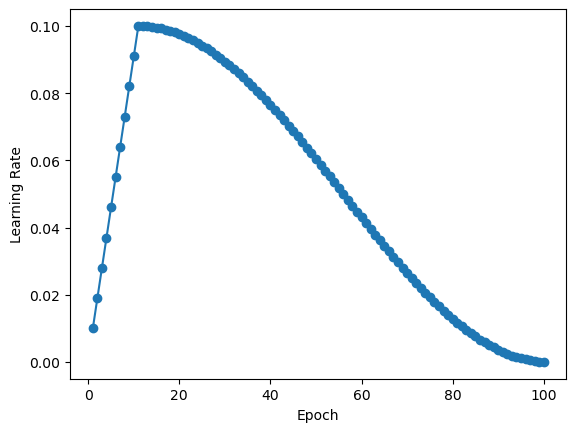

All tests passed!


In [24]:
warmup_epochs = int(num_epochs * 0.1)

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor = 0.1,
    end_factor=1.0,
    total_iters=warmup_epochs
)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,
    eta_min=0.0 # TODO
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

lr_history = simulate_train_model(model, optimizer, scheduler, num_epochs) 

assert torch.allclose(torch.tensor(sum(lr_history)), torch.tensor(5.055000000000001), rtol=1e-6), "Learning rate scheduler is not correct."
print('\033[92mAll tests passed!')

# Training BetterCNN
<mark>실습</mark> 다양한 regularization 기법들과 Hyperparameter tuning, CNN 모델 구조 개선을 통하여 더 높은 이미지 분류 정확도를 달성하세요.

- 목표 : CIFAR-10 데이터셋 `validaton accuracy > 83.0%`, `test accuracy > 83.0%`
- pytest가 통과하는 한, 아래의 코드를 모두 자유롭게 수정할 수 있습니다 (단, `train_utils.py`파일은 수정할 수 <u>없습니다</u>). 

✅ 자유롭게 실험 가능한 항목:
   - learning rate (lr) and lr_scheduler
   - Regularization methods (Weight decay, dropout, BatchNorm, data augmentation, ...)
   - `BetterCNN` 클래스 내의 네트워크 구조: 아래 모듈들만 사용 가능합니다
     - `nn.Sequential`, `nn.Conv2d`, `nn.MaxPool2d`, `nn.ReLU()`, `nn.Linear`, `nn.Flatten()`, [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html), [`nn.BatchNorm2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [`nn.BatchNorm1d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

❌ 사용이 금지된 항목: 
- Optimizer
   - SGD with momentum
   - `torch.optim.Adam`, `torch.optim.AdamW` 등 `SGD` 제외한 다른 모든 optimizer
 - 사전 정의된 딥러닝 모델: `torchvision.models`
 - 하이퍼파라미터 : `num_workers`, `batch_size`는 <u>변경 불가</u>.

<mark>주의</mark> 해당 정확도를 달성한 모델의 checkpoint 파일(`submitted_checkpoints/best_model.pth`)을 github에 함께 push하세요.

힌트 & 팁
- 한번에 하나의 변수만만 바꿔가며 실험을 진행해보세요. 한번에 여러개의 변수를 동시에 수정하면 결과 해석과 원인 분석이 어려워집니다.
- 실험마다 `wandb_experiment_name`을 변경하여 고유한 이름으로 실험 결과를 관리할 수 있습니다.

In [34]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Subset

import numpy as np
from sklearn.model_selection import train_test_split

from train_utils import visualize_few_samples, train_model, load_and_evaluate_model

In [35]:
def load_cifar10_datasets(data_root_dir):
    normalize = transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) 

    train_transforms = transforms.Compose([
        ##### YOUR CODE START #####
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        ##### YOUR CODE END #####
        transforms.ToTensor(),
        normalize,
    ])

    eval_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    
    train_dataset_full = datasets.CIFAR10(root=data_root_dir, train=True, download=False, transform=train_transforms)
    val_dataset_full = datasets.CIFAR10(root=data_root_dir, train=True, download=False, transform=eval_transforms)
    test_dataset = datasets.CIFAR10(root=data_root_dir, train=False, download=False, transform=eval_transforms)

    train_indices, val_indices = train_test_split(np.arange(len(train_dataset_full)), 
                                                  test_size = 0.2, random_state = 42)
    
    train_dataset = Subset(train_dataset_full, train_indices)
    val_dataset = Subset(val_dataset_full, val_indices)

    train_dataset.classes = train_dataset_full.classes  # monkey‐patch class informations
    train_dataset.class_to_idx = train_dataset_full.class_to_idx

    return train_dataset, val_dataset, test_dataset

In [36]:
train_dataset, val_dataset, test_dataset = load_cifar10_datasets("/datasets")
print("train_dataset size: ", len(train_dataset))
print("val_dataset size: ", len(val_dataset))
print("test_dataset size: ", len(test_dataset))

train_dataset size:  40000
val_dataset size:  10000
test_dataset size:  10000


Train dataset: 


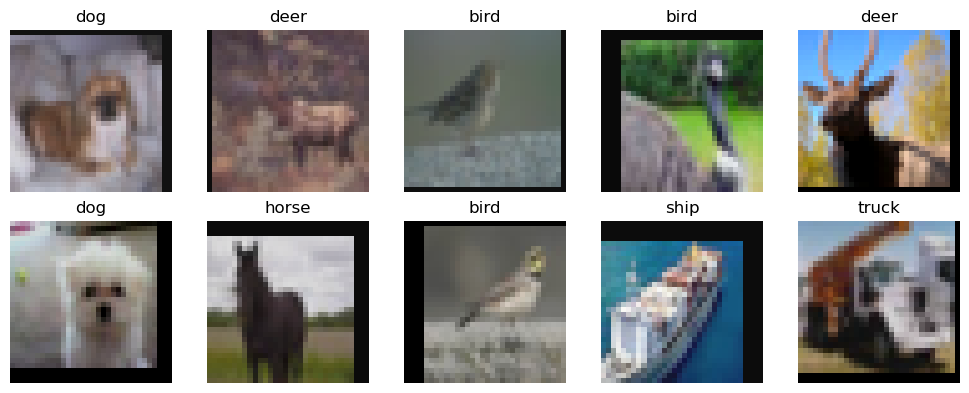

Validation dataset: 


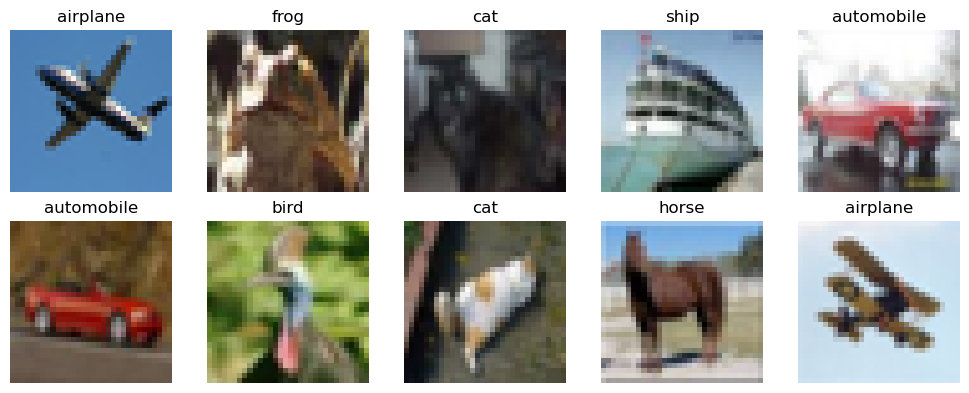

In [37]:
print("Train dataset: ")    
visualize_few_samples(train_dataset, cols = 5, rows = 2)

print("Validation dataset: ")    
visualize_few_samples(val_dataset, cols = 5, rows = 2)

In [38]:
class BetterCNN(nn.Module):
    def __init__(self, out_dim):
        super().__init__()

        ##### YOUR CODE START #####  
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_dim)
)
        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####  
        logits = self.net(x)
        ##### YOUR CODE END #####
        return logits

In [39]:
# Test forward pass
model = BetterCNN(out_dim = 10)
print(model)

X = torch.rand(16, 3, 32, 32) # dummy data for testing with batch_size 16
logits = model(X) 

print("\nlogits.shape: ", logits.shape)

BetterCNN(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (1

In [42]:
config = {
    "mode": "train",  # Options: "train", "eval"
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    ## data and preprocessing settings
    "data_root_dir": '/datasets',
    "num_workers": 4,

    ## Training Hyperparams
    "batch_size": 128,
    "learning_rate": 1e-2,  # TODO
    "num_epochs": 120,   # TODO

    ## checkpoints
    "checkpoint_path": "submitted_checkpoints/checkpoint.pth",    # Path to save the most recent checkpoint
    "best_model_path": "submitted_checkpoints/best_model.pth",    # Path to save the best model checkpoint
    "checkpoint_save_interval": 1,                     # Save a checkpoint every N epochs
    "resume_training": None,    # Options: "latest", "best", or None

    ## WandB logging
    "wandb_project_name": "CIFAR10-experiments",
    "wandb_experiment_name" : "BetterCNN",
    "model_architecture": "CNN",
    "dataset_name": "CIFAR10"
}

def main_BetterCNN(config):
    train_dataset, val_dataset, test_dataset = load_cifar10_datasets(config["data_root_dir"])
    num_classes = len(train_dataset.classes)

    model = BetterCNN(out_dim=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"], weight_decay=5e-4)   # TODO
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.2) # TODO

    print(f"Using {config['device']} device")
    print("Number of trainable model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    if config["mode"] == "train":
        val_accuracy = train_model(model, train_dataset, val_dataset, criterion, optimizer, scheduler, config)
        return val_accuracy
    elif config["mode"] == "eval":
        test_accuracy = load_and_evaluate_model(model, test_dataset, criterion, optimizer, scheduler, config)
        return test_accuracy
    else:
        raise ValueError(f"Unknown mode: {config['mode']}")

In [43]:
main_BetterCNN(config)

Using cuda device
Number of trainable model parameters:  2474506


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 360.98it/s, avg_metrics=Loss: 4.5556e-01 (n=10000), Accuracy:  84.12 (n=10000)]


Learning Rate,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████████████████████████
Train Loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▅▆▆▆▇▆▇▇▇▇██████████████████████████
Validation Loss,█▆▆▄▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Learning Rate,0.0004
Train Accuracy,84.1875
Train Loss,0.45474
Validation Accuracy,84.12
Validation Loss,0.45556


84.2

<mark>주의</mark> 실습 과제를 제출하기 전 아래 코드를 통해 저장된 checkpoint가 `test set accuracy > 83.0%`의 성능을 달성했는지 다시 한번 확인해보세요.

In [44]:
config["mode"] = "eval"
main_BetterCNN(config)

Using cuda device
Number of trainable model parameters:  2474506
=> loaded checkpoint 'submitted_checkpoints/best_model.pth' (epoch 99)


Validation/Test: 100%|██████████| 79/79 [00:00<00:00, 370.06it/s, avg_metrics=Loss: 4.6867e-01 (n=10000), Accuracy:  83.83 (n=10000)]

Test-set Accuracy: 83.83%


83.83